# Homework 2

In [1]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import csv

## Exercise 1

In [2]:
# first 10 entrys of female BMI and stature:
female_data = []
with open("female_train_data.csv", "r") as csv_file:
    female_reader = csv.reader(csv_file, delimiter=',')
    for row in female_reader:
        if row[0] != "index":
            row[1] = float(row[1])/10
            row[2] = float(row[2])/1000
            female_data.append([row[1],row[2]])
csv_file.close()
female_data = np.matrix(female_data)
print(female_data[0:10])

[[2.82  1.563]
 [2.22  1.716]
 [2.71  1.484]
 [2.81  1.651]
 [2.55  1.548]
 [2.3   1.665]
 [3.56  1.564]
 [3.11  1.676]
 [2.46  1.69 ]
 [4.3   1.704]]


In [3]:
# first 10 entries of male BMI and stature
male_data=[]
with open("male_train_data.csv", "r") as csv_file:
    male_reader = csv.reader(csv_file, delimiter=',')
    for row in male_reader:
        if row[0] != "index":
            row[1] = float(row[1])/10
            row[2] = float(row[2])/1000
            male_data.append([row[1],row[2]])
csv_file.close()
male_data = np.matrix(male_data)
print(male_data[0:10])

[[3.    1.679]
 [2.56  1.586]
 [2.42  1.773]
 [2.74  1.816]
 [2.59  1.809]
 [2.53  1.662]
 [2.27  1.829]
 [2.54  1.686]
 [3.41  1.761]
 [3.34  1.797]]


## Exercise 2

2-a

$||y-X\theta||^{2} = (y-X\theta)^{T}(y-X\theta) = y^{T}y - y^{T}X\theta-\theta^{T}X^{T}y - \theta^{T}X^{T}X\theta = y^{T}y-2y^{T}X\theta+\theta^{T}X^{T}X\theta$

$\frac{\partial(y^{T}y-2y^{T}X\theta+\theta^{T}X^{T}X\theta)}{\partial \theta} = -2X^{T}y+2X^{T}X\theta$

$-2X^{T}y+2X^{T}X\theta = 0$

$\theta = (X^{T}X)^{-1}X^{T}y$

The conditions that the solution is unique is X is full rank.

Two techniques that can be used when $X^{T}X$ is not invertible are:
- regularization
- pseudo-inversion


In [4]:
#2-b
y_male = np.matrix(np.ones(male_data.shape[0])).T
y_female = np.matrix(-1*np.ones(female_data.shape[0])).T
y = np.vstack((y_male,y_female))
X = np.vstack((male_data,female_data))
bias = np.matrix(np.ones(y.shape[0]))
X=np.vstack((X.T,bias)).T
theta_direct_solve = np.linalg.inv((X.T)@X)@(X.T)@y
print(theta_direct_solve)

[[ -0.12339677]
 [  6.67486843]
 [-10.7017505 ]]


In [5]:
#2-c
d = 3
theta = cp.Variable(d)
y=np.array(y).reshape((-1,))
objective = cp.Minimize(cp.sum_squares(y-X@theta))
prob = cp.Problem(objective)
prob.solve()
theta_vanilla = theta.value
print(theta_vanilla)

[ -0.12339677   6.67486843 -10.7017505 ]


2-d

As we derived in the 2-a, the gradient of the optimization function is $-2X^{T}y+2X^{T}X\theta$

We have $f(\theta) = (y-X\theta)^{T}(y-X\theta) = y^{T}y-2y^{T}X\theta+\theta^{T}X^{T}X\theta$

Throw the constant term, we end up with $f(\theta) = -2y^{T}X\theta+\theta^{T}X^{T}X\theta$

Now, let's map this to the lecture notes equation where $f(x) = \frac{1}{2}x^{T}Hx+c^{T}x$

we have $H = 2X^{T}X,\ c=(-2y^{T}X)^{T} = -2X^{T}y$

Therefore, $\alpha^{k}= \frac{\nabla(f(\theta)^{k})^{T}d^{k}}{(d^{k})^{T}Hd^{k}}$

$\nabla f(\theta) = 2X^{T}X\theta-2X^{T}y$

$d^{k} = \nabla f$

Substitue above into equation, we end up with:

$\alpha^{k} = \frac{(2X^{T}X\theta-2X^{T}y)^{T}\nabla f}{(\nabla f)^{T}2X^{T}X \nabla f} =\frac{\nabla f^{T}X^{T}X\theta -y^{T}X\nabla f}{(\nabla f)^{T}X^{T}X \nabla f}$

In [6]:
#2-e
d = 3
y=np.array(y).reshape((-1,1))
theta_grad = np.matrix(np.zeros(d)).T
XtX = X.T@X

for i in range(50000):
    grad =2*XtX@theta_grad - 2*X.T@y
    alpha = (grad.T@XtX@theta_grad-y.T@X@grad)/(grad.T@XtX@grad)
    theta_grad = theta_grad - np.multiply(alpha[0][0],grad)
print(theta_grad)

[[ -0.12339677]
 [  6.67486843]
 [-10.7017505 ]]


[[ -0.12339677]
 [  6.67486843]
 [-10.7017505 ]]


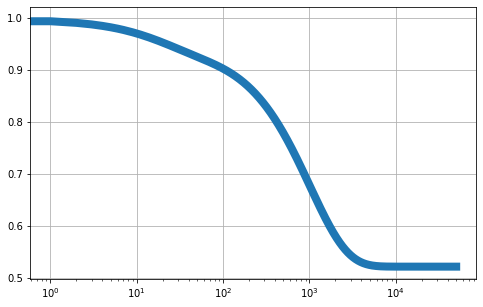

In [133]:
#2-f
d = 3
y=np.array(y).reshape((-1,1))
theta_grad = np.matrix(np.zeros(d)).T
XtX = X.T@X
loss = np.zeros(50000)
N=y.shape[0]

for i in range(50000):
    grad =2*XtX@theta_grad - 2*X.T@y
    alpha =((grad.T@XtX@theta_grad-y.T@X@grad)/(grad.T@XtX@grad))
    theta_grad = theta_grad - np.multiply(alpha[0][0],grad)
    loss[i] = np.linalg.norm(np.dot(X, theta_grad)-y)**2/N
    #loss[i] = np.linalg.norm(np.dot(X, theta_grad)-y)**2/N
print(theta_grad)
fig = plt.figure(figsize = (8,5))   
plt.semilogx(loss,linewidth=8)
plt.grid()

In [150]:
#2-g
d = 3
y=np.array(y).reshape((-1,1))
theta_grad = np.matrix(np.zeros(d)).T
XtX = X.T@X
loss_momentum = np.zeros(50000)
N=y.shape[0]
beta = 0.9
dJ_old = np.matrix(np.zeros(d)).T
print(XtX)

for i in range(50000):
    dJ = X.T@X@theta_grad - X.T@y
    dd = beta*dJ_old + (1-beta)*dJ
    alpha  = ((dJ.T@dd) / (dd.T@XtX@dd))
    theta_grad  = theta_grad - alpha[0,0]*dd
    dJ_old = dJ
    #loss[i] = np.linalg.norm(np.dot(X, theta_grad)-y)
    loss_momentum[i] = np.linalg.norm(np.matmul(X, theta_grad)-y)**2/N
print(theta_grad)


[[28754.7541     15495.257172    9383.69      ]
 [15495.257172    8835.21241756  5326.9006    ]
 [ 9383.69        5326.9006      3224.        ]]
[[ -0.12339677]
 [  6.67486843]
 [-10.7017505 ]]


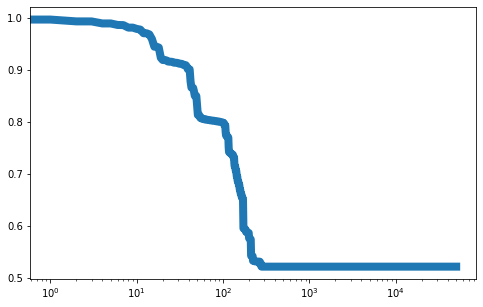

In [149]:
#2-h
fig = plt.figure(figsize = (8,5))   
plt.semilogx(loss_momentum,linewidth=8)

## Exercise 3

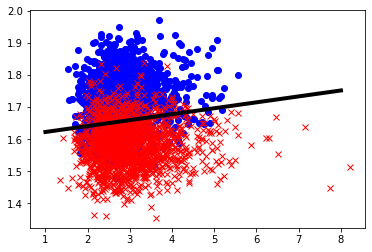

In [10]:
#3-a
plt.plot(np.array(male_data.T)[0],np.array(male_data.T)[1],'bo')
plt.plot(np.array(female_data.T)[0],np.array(female_data.T)[1],'rx')
x_1=np.linspace(1,8,100)
x_2 = np.array(-(theta_grad[0]/theta_grad[1])*x_1-(theta_grad[2]/theta_grad[1])).T
plt.plot(x_1,x_2,'k',linewidth=4)

In [127]:
#b-i
female_test = []
with open("female_test_data.csv", "r") as csv_file:
    female_reader = csv.reader(csv_file, delimiter=',')
    for row in female_reader:
        if row[0] != "index":
            row[1] = float(row[1])/10
            row[2] = float(row[2])/1000
            female_test.append([row[1],row[2]])
csv_file.close()
female_test = np.matrix(female_test)
bias = np.ones(female_test.shape[0])
female_test = np.vstack((female_test.T,bias)).T
y_female_test = female_test@theta_grad
male_count = np.sum(np.array(y_female_test.T)[0]>0,axis=0)
type_1_err = male_count/female_test.shape[0]
print("Type 1 error of classifying male is {}".format(type_1_err))


Type 1 error of classifying male is 0.14171656686626746


In [128]:
#b-ii
male_test = []
with open("male_test_data.csv", "r") as csv_file:
    male_reader = csv.reader(csv_file, delimiter=',')
    for row in male_reader:
        if row[0] != "index":
            row[1] = float(row[1])/10
            row[2] = float(row[2])/1000
            male_test.append([row[1],row[2]])
csv_file.close()
male_test = np.matrix(male_test)
bias = np.ones(male_test.shape[0])
male_test = np.vstack((male_test.T,bias)).T
y_male_test = male_test@theta_grad
female_count = np.sum(np.array(y_male_test.T)[0]<0,axis=0)
type_2_err = female_count/male_test.shape[0]
print("Type 2 error of classifying female is {}".format(type_2_err))

Type 2 error of classifying female is 0.17964071856287425


In [13]:
#b-iii
TP = np.sum(np.array(y_male_test.T)[0]>0,axis=0)
FP = np.sum(np.array(y_female_test.T)[0]>0,axis=0)
FN = np.sum(np.array(y_male_test.T)[0]<0,axis=0)
precision = TP/(TP+FP)
recall = TP/(TP+FN)
print("The precision of this classifier is {}".format(precision))
print("The recall of this classifier is {}".format(recall))

The precision of this classifier is 0.8526970954356846
The recall of this classifier is 0.8203592814371258


## Exercise 4

Text(0, 0.5, '$||X\\theta_{\\lambda}-y||_{2}^{2}$')

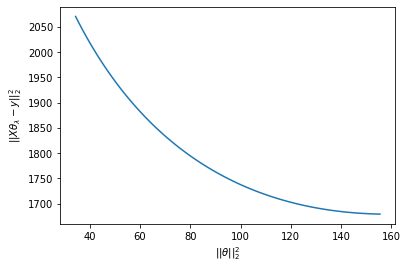

In [152]:
#4-a
lamda = np.arange(0.1,10,0.1)
y_male = np.matrix(np.ones(male_data.shape[0])).T
y_female = np.matrix(-1*np.ones(female_data.shape[0])).T
y = np.vstack((y_male,y_female))
X = np.vstack((male_data,female_data))
bias = np.matrix(np.ones(y.shape[0]))
X=np.vstack((X.T,bias)).T
N=y.shape[0]

theta_norm = []
loss_norm = []
for each in lamda:
    theta_tmp = np.linalg.inv(X.T@X+each*np.eye(X.shape[1]))@X.T@y
    norm_tmp = np.linalg.norm(np.dot(X, theta_tmp)-y)**2
    norm_theta = np.linalg.norm(theta_tmp)**2
    loss_norm.append(norm_tmp)
    theta_norm.append(norm_theta)
plt.plot(theta_norm,loss_norm)
plt.xlabel(r"$||\theta||_{2}^{2}$")
plt.ylabel(r"$||X\theta_{\lambda}-y||_{2}^{2}$")

Text(0, 0.5, '$||X\\theta_{\\lambda}-y||_{2}^{2}$')

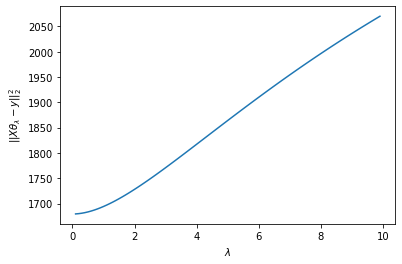

In [153]:
plt.plot(lamda,loss_norm)
plt.xlabel(r"$\lambda$")
plt.ylabel(r"$||X\theta_{\lambda}-y||_{2}^{2}$")

Text(0, 0.5, '$||\\theta||_{2}^{2}$')

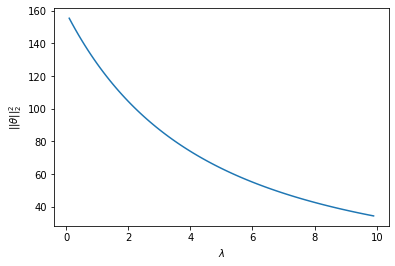

In [154]:
plt.plot(lamda,theta_norm)
plt.xlabel(r"$\lambda$")
plt.ylabel(r"$||\theta||_{2}^{2}$")

#4-b-i

For equation 4, rearrange the constraints, we have 

$\underset{\theta \in R^{d}}{\mathrm{argmin}} ||X\theta-y||_{2}^{2}$, subject to $\alpha-||\theta||_{2}^{2}\geq 0$

Lagrangian for 4 is: $\mathcal{L}(\theta,\gamma_{\alpha}) = ||X\theta-y||_{2}^{2}-\gamma_{\alpha}(\alpha-||\theta||_{2}^{2})$

For equation 5, rearrange the constraints, we have

$\underset{\theta \in R^{d}}{\mathrm{argmin}} ||\theta||_{2}^{2}$, subject to $\epsilon-||X\theta-y||_{2}^{2}\geq 0$

Lagrangian for 5 is: $\mathcal{L}(\theta,\gamma_{\epsilon}) = ||\theta||_{2}^{2}-\gamma_{\epsilon}(\epsilon-||X\theta-y||_{2}^{2})$

#4-b-ii

For equation 3, the first order condition is :
- $\nabla_{\theta}\mathcal{L}(\theta,\lambda)=0$
- $||\theta||_{2}^{2}=0$

For equation 4, we have $g(\theta)=\alpha - ||\theta||_{2}^{2}\geq0$, and the Lagrangian multiplier is $\gamma_{\alpha}$, therefore, first order condition is :
- $\nabla_{\theta}\mathcal{L}(\theta,\gamma_{\alpha})=0$
- $g_{i}(\theta)\geq 0$
- $\gamma_{\alpha_{i}} \geq 0$
- $\gamma_{\alpha_{i}}g_{i}(\theta) = 0$

For equation 5, we have $g(\theta)=\epsilon - ||X\theta-y||_{2}^{2}\geq 0$, and the Lagrangian multiplier is $\gamma_{\epsilon}$, therefore, first order condition is :
- $\nabla_{\theta}\mathcal{L}(\theta,\gamma_{\epsilon})=0$
- $g_{i}(\theta)\geq 0$
- $\gamma_{\epsilon_{i}} \geq 0$
- $\gamma_{\epsilon_{i}}g_{i}(\theta) = 0$


#4-b-iii

For this question, we will choose an arbitrary $\lambda=3$ to solve for $\theta_{\lambda}$ first from equation 3, then use that to calculate the corrsponding value for $\alpha$ and $\gamma_{\alpha}$. 

If we take derative for equation 3, we see that

$\nabla_{\theta}\mathcal{L}(\theta,\lambda) = 2X^{T}X\theta-2X^{T}y+2\lambda \theta$

If we take derative of equation 4, we have

$\nabla_{\theta}\mathcal{L}(\theta,\gamma_{\alpha}) = 2X^{T}X\theta-2X^{T}y+2\gamma_{\alpha}\theta$

So, it is easy to see that $\gamma_{\alpha}$ should be equal to $\lambda$

As shown in the following code, which validate the above claim. Since $\lambda \geq 0$, therefore, $\gamma_{\alpha} \geq 0$, which satisfy $\textbf{Dual Feasibility}$ from KKT.

As $\lambda = \gamma_{\alpha}$, so the same $\theta_{\lambda}$ will set $\nabla_{\theta}\mathcal{L}(\theta,\gamma_{\alpha})=0$ as well, which satisfy $\textbf{Stationarity}$ from KKT

For $g(\theta)\geq 0$, we have $\alpha \geq ||\theta_{\lambda}||_{2}^{2}$

We also need $\gamma_{\alpha}g(\theta_{\lambda}) = 0$,since $\gamma_{\alpha}>0$, therefore, $\alpha = ||\theta_{\lambda}||_{2}^{2}$, which makes $g(\theta_{\lambda}) = 0$

Thus, it satisfy $\textbf{Complementary Slackness}$ and $\textbf{Primal Feasibility}$ as well


In [155]:
#4-b-iii
lamda = 3
y_male = np.matrix(np.ones(male_data.shape[0])).T
y_female = np.matrix(-1*np.ones(female_data.shape[0])).T
y = np.vstack((y_male,y_female))
X = np.vstack((male_data,female_data))
bias = np.matrix(np.ones(y.shape[0]))
X=np.vstack((X.T,bias)).T
N=y.shape[0]

theta_lambda = np.linalg.inv(X.T@X+lamda*np.eye(X.shape[1]))@(X.T)@y
norm_loss = np.linalg.norm(np.dot(X, theta_lambda)-y)**2
norm_theta = np.linalg.norm(theta_lambda)**2
print("theta_lambda = {}".format(theta_lambda))
print("theta_norm = {}".format(norm_theta))

gamma_alpha = (np.linalg.inv(theta_lambda.T@theta_lambda))@(theta_lambda.T)@(X.T@y-X.T@X@theta_lambda)
print("gamme_alpha = {}".format(gamma_alpha))


theta_lambda = [[-0.18073616]
 [ 5.05702756]
 [-7.85445029]]
theta_norm = 87.29858264746179
gamme_alpha = [[3.]]


#4-b-iv

For this question, we will choose an arbitrary $\lambda=3$ to solve for $\theta_{\lambda}$ first from equation 3, then use that to calculate the corrsponding value for $\alpha$ and $\gamma_{\alpha}$. 

If we take derative for equation 3, we see that

$\nabla_{\theta}\mathcal{L}(\theta,\lambda) = 2X^{T}X\theta-2X^{T}y+2\lambda \theta$

If we take derative of equation 5, we have

$\nabla_{\theta}\mathcal{L}(\theta,\gamma_{\alpha}) = 2\gamma_{\epsilon}X^{T}X\theta -2\gamma_{\epsilon}X^{T}y+2\theta$

So, it is easy to see that $\gamma_{\epsilon}$ should be equal to $\frac{1}{\lambda}$

As shown in the following code, which validate the above claim. Since $\lambda \geq 0$, therefore, $\gamma_{\epsilon} \geq 0$, which satisfy $\textbf{Dual Feasibility}$ from KKT.

As $\lambda = \frac{1}{\gamma_{\epsilon}}$, so the same $\theta_{\lambda}$ will set $\nabla_{\theta}\mathcal{L}(\theta,\gamma_{\alpha})=0$ as well, which satisfy $\textbf{Stationarity}$ from KKT

For $g(\theta)\geq 0$, we have $\alpha \geq ||\theta_{\lambda}||_{2}^{2}$

We also need $\gamma_{\epsilon}g(\theta_{\lambda}) = 0$, since $\gamma_{\epsilon} >0$, therefore, $\alpha = ||\theta_{\lambda}||_{2}^{2}$, which makes $g(\theta_{\lambda}) = 0$

Thus, it satisfy $\textbf{Complementary Slackness}$ and $\textbf{Primal Feasibility}$ as well

In [156]:
#4-b-iv
lamda = 3
y_male = np.matrix(np.ones(male_data.shape[0])).T
y_female = np.matrix(-1*np.ones(female_data.shape[0])).T
y = np.vstack((y_male,y_female))
X = np.vstack((male_data,female_data))
bias = np.matrix(np.ones(y.shape[0]))
X=np.vstack((X.T,bias)).T
N=y.shape[0]

theta_lambda = np.linalg.inv(X.T@X+lamda*np.eye(X.shape[1]))@(X.T)@y
norm_loss = np.linalg.norm(np.dot(X, theta_lambda)-y)**2
norm_theta = np.linalg.norm(theta_lambda)**2
gamma_epsilon = 1/lamda
print("theta_lambda = {}".format(theta_lambda))
print("theta_norm = {}".format(norm_theta))
print("gradient of equation 5 at gamme_epsilon = {}".format(gamma_epsilon*X.T@X@theta_lambda-gamma_epsilon*X.T@y+theta_lambda))
print("gamme_epsilon = {}".format(gamma_epsilon))

theta_lambda = [[-0.18073616]
 [ 5.05702756]
 [-7.85445029]]
theta_norm = 87.29858264746179
gradient of equation 5 at gamme_epsilon = [[8.08617062e-12]
 [5.36726219e-12]
 [9.56745794e-12]]
gamme_epsilon = 0.3333333333333333


#4-b-v

As we have already shown in 4-b-iii, when we fix $\lambda=3$, with $\theta_{\lambda} = \begin{bmatrix}-0.18073616&5.05702756&-7.85445029\end{bmatrix}^{T}$, $\alpha = ||\theta_{\lambda}||_{2}^{2}=87.29858264746179$, $\gamma_{\alpha} = 3$, $\theta_{\lambda}$ satisfy KKT, which is only the first order necessary condition. To show that $\theta_{\lambda}$ is the solution for equation 4, we need to show that it satisfy the second order optimality, therefore we take the second derative of equation 4 and end up with

$\nabla_{\theta}^{2}\mathcal{L}(\theta,\gamma_{\alpha}) = 2X^{T}X+2\gamma_{\alpha}I$

now we subsititue the $\gamma_{\alpha}=\lambda=3$ into the equation, we can calculate the second order optimal expression as below. Then we do an eigen decomposition and see that all eigen value are non-negative, which indicates that $d^{T}(2X^{T}X+2\gamma_{\alpha}I)d>0 \ \forall d$, Therefore, the second order of optimality is satified by $\theta_{\lambda}$ as well. So $\theta_{\lambda}$ is the solution for equation 4.

In [158]:
#4-b-v
second_order = 2*X.T@X+2*lamda*np.eye(X.shape[1])
print(np.linalg.eig(second_order))

(array([8.07066531e+04, 9.16203292e+02, 2.30766327e+01]), matrix([[ 0.84223101,  0.53880977, -0.01819241],
        [ 0.46127391, -0.73767815, -0.49300844],
        [ 0.27905791, -0.40683531,  0.8698343 ]]))
